# Feature Extraction Phase
In this notebook I'm running the feature extraction phase using an Inception Convolutional Neural Network as the feature extraction model trained with the pre-processed data as well as optimized with a Bayesian Optimization process.

**Author**: Arthur G.

## Loading Dependencies
Loading and setting up all the dependencies for this notebook.

In [29]:
# libs
import os
import time
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from pycaret.classification import *
from keras_tuner import HyperModel, Objective
from keras_tuner.tuners import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# settings
seed = np.random.seed(42)
warnings.filterwarnings("ignore")

## Helper Functions
A set of helper functions and classes for the automation of model optimization.

In [2]:
class InceptionHyperModel(HyperModel):
    """Builds the base Inception model for dynamic optimization."""
    
    def build(self, hp):
        """Initiate the model before the bayesian process gets started."""
        input_tensor = tf.keras.layers.Input(shape=(1, 300, 20)) # era 1,300,1

        
        # bottleneck layer
        x = tf.keras.layers.Conv2D(
                filters=hp.Int("n_filters_1_bn", min_value=16, max_value=64, step=16), 
                kernel_size=(1, 1), 
                strides=1, 
                padding='same', 
                activation='relu'
        )(input_tensor)
        x = tf.keras.layers.Conv2D(
                filters=hp.Int("n_filters_2_bn", min_value=16, max_value=64, step=16), 
                kernel_size=hp.Int("kernel_size_bn", min_value=2, max_value=4, step=1), 
                strides=1, 
                padding='same', 
                activation='relu'
        )(x)
        x = tf.keras.layers.Conv2D(
                filters=hp.Int("n_filters_3_bn", min_value=16, max_value=64, step=16), 
                kernel_size=(1, 1), 
                strides=1, 
                padding='same', 
                activation='relu'
        )(x)
        x = tf.keras.layers.Dropout(
                hp.Choice("dropout_rate_bn", values=[0.05, 0.5], default=0.5)
        )(x)
        

        # dynamic efficient inception blocks
        for i in range(hp.Int("n_incep_blocks", min_value=2, max_value=4, step=1)):
            x = tf.keras.layers.Conv2D(
                    filters=hp.Int("n_filters_1_ib", min_value=16, max_value=64, step=16), 
                    kernel_size=(1, 1), 
                    padding="same", 
                    activation="relu"
            )(x)
            x = tf.keras.layers.Conv2D(
                    filters=hp.Int("n_filters_2_ib", min_value=16, max_value=64, step=16), 
                    kernel_size=(1, 1), 
                    padding="same", 
                    activation="relu"
            )(x)
            x = tf.keras.layers.Conv2D(
                    filters=hp.Int("n_filters_3_ib", min_value=16, max_value=64, step=16), 
                    kernel_size=(3, 3), 
                    padding="same", 
                    activation="relu"
            )(x)
            x = tf.keras.layers.Conv2D(
                    filters=hp.Int("n_filters_4_ib", min_value=16, max_value=64, step=16), 
                    kernel_size=(1, 1), 
                    padding="same", 
                    activation="relu"
            )(x)
            x = tf.keras.layers.Conv2D(
                    filters=hp.Int("n_filters_5_ib", min_value=16, max_value=64, step=16), 
                    kernel_size=(5, 5), 
                    padding="same", 
                    activation="relu"
            )(x)
            x = tf.keras.layers.MaxPooling2D(
                    pool_size=(3, 3), 
                    strides=(1, 1), 
                    padding='same'
            )(x)
            x = tf.keras.layers.Conv2D(
                filters=hp.Int("n_filters_6_ib", min_value=16, max_value=64, step=16), 
                kernel_size=(1, 1), 
                padding="same", 
                activation="relu"
            )(x)
        

        # fully connected layer
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        for i in range(hp.Int("n_fc_blocks", min_value=2, max_value=4, step=1)):
            x = tf.keras.layers.Dense(
                    units=hp.Int("n_dense_nodes_1_fc", min_value=32, max_value=256, step=32), 
                    activation='relu'
            )(x)
            x = tf.keras.layers.Dropout(
                    hp.Choice("dropout_rate_fc", values=[0.05, 0.5], default=0.5)
            )(x)
            x = tf.keras.layers.Dense(
                    units=hp.Int(
                        "n_dense_nodes_2_fc", min_value=32, max_value=256, step=32) \
                        // hp.Int("dense_nodes_div", min_value=2, max_value=8, step=2), 
                        activation='relu'
            )(x)
        
        output_tensor = tf.keras.layers.Dense(
            4, 
            activation='softmax'
        )(x)
        

        # model compilation
        model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
        model.compile(
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=hp.Choice(
                "optimizer", 
                values=[
                    "sgd", "rmsprop", "adam", 
                    "adadelta", "adagrad", 
                    "adamax", "nadam"
                ], default="adam"
            )
        )
        
        return model
    

def get_features_extracted(model, final_layer: str, sample: np.ndarray):
    """
    This function extracts outputs from a given layer
    name.
    """
    sample = np.expand_dims(sample, axis=0)
    output = np.array(
        tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(final_layer).output)(sample)
    )
    
    return output


## Feature Extraction Pipeline
Building the feature extraction pipeline using an Inception Convolutional Neural Network.

Loading and preparing the DCE-based dataset.

In [3]:
# loading data and targets
data = np.loadtxt(os.path.join("..","..", "data", "processed", "EEG_filt_20_electrodes.csv"), delimiter=',')
targets = np.loadtxt(os.path.join("..","..", "data", "processed", "EEG_filt_first_8_electrodes_targets.csv"), delimiter=',')

# encoding targets (from string to int)
targets[targets == 0] = 0
targets[targets == 1] = 0 # 19494 subjects of this class
targets[targets == 2] = 1
targets[targets == 3] = 1 # 11286 subjects of this class
targets = targets.astype(int)

print(f"Original data shape: {data.shape}")
data_reshape = data.reshape(10800, 1,300, 20) 

print(f"Reshaped data shape: {data_reshape.shape}")
print(f"Original targets shape: {targets.shape}")

Original data shape: (3240000, 20)
Reshaped data shape: (10800, 1, 300, 20)
Original targets shape: (10800,)


In [4]:
print(f"data: {data[3,1]}, data_reshape: {data_reshape[0,0,3,1]}")
data_reshape.shape

data: 65.4093722285802, data_reshape: 65.4093722285802


(10800, 1, 300, 20)

### Train-Test-Split
Splitting DCE-based dataset into train/holdout sets.

In [5]:
x_train, x_holdout, y_train, y_holdout = train_test_split(
    data_reshape,
    targets,
    test_size=0.2,
    shuffle=True,
    random_state=seed
)

print(f"Original data train set: {x_train.shape}")
print(f"Holdout data test set: {x_holdout.shape}")

Original data train set: (8640, 1, 300, 20)
Holdout data test set: (2160, 1, 300, 20)


### Architecture Optimization
Building the optimizable iCNN skeleton.

In [6]:
# loading the Inception skeleton
inception_hyper_model = InceptionHyperModel()

Setting up the architecture tuner.

In [7]:
# setting up the optimization process
tuner = BayesianOptimization(
    hypermodel=inception_hyper_model,
    objective="val_loss",
    num_initial_points=25,
    max_trials=15,
    directory=os.path.join("..","..", "models","updatedInception"),
    project_name="20_electrodes_2_classes_feature_extractor",
    seed=seed
)

INFO:tensorflow:Reloading Oracle from existing project ..\..\models\updatedInception\20_electrodes_2_classes_feature_extractor\oracle.json
INFO:tensorflow:Reloading Tuner from ..\..\models\updatedInception\20_electrodes_2_classes_feature_extractor\tuner0.json


Defining callback functions.

In [8]:
# defining callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=20
    ),
    ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.1, 
        patience=10, 
        mode="auto", 
        min_delta=0.0001, 
        cooldown=0, 
        min_lr=1.0e-6
    )
]

Running the tuner.

In [9]:
# running the search
tuner.search(
    x_train,
    y_train,
    epochs=250,
    validation_split=0.2,
    batch_size=32,
    callbacks=[callbacks]
)

INFO:tensorflow:Oracle triggered exit


### Building The Model
Getting the best feature extraction model from the tuner.

In [10]:
best_feature_extractor = tuner.get_best_models(num_models=1)[0]

### Feature Extraction Process
Using the model to extract predictive patterns from the DCE-based dataset.

In [11]:
train_features = []
holdout_features = []

# extracting trian features
for sample in x_train:
    sample_features = get_features_extracted(best_feature_extractor, "global_average_pooling2d", sample)
    train_features.append(sample_features)
    
# extracting holdout features
for sample in x_holdout:
    sample_features = get_features_extracted(best_feature_extractor, "global_average_pooling2d", sample)
    holdout_features.append(sample_features)

# assembling feature dataframes
train_features_df = pd.DataFrame(np.array(train_features).reshape((len(train_features),len(train_features[0][0])))) 
train_features_df["CLASS"] = y_train

holdout_features_df = pd.DataFrame(np.array(holdout_features).reshape((len(holdout_features),len(holdout_features[0][0]))))
holdout_features_df["CLASS"] = y_holdout

print(f"Train dataset shape: {train_features_df.shape}")
print(f"Holdout dataset shape: {holdout_features_df.shape}")

Train dataset shape: (8640, 49)
Holdout dataset shape: (2160, 49)


## Machine Learning Classification Experiment
Renaming the columns to avoid errors.

In [12]:
train_features_df.columns = train_features_df.columns.astype(str)
holdout_features_df.columns = holdout_features_df.columns.astype(str)

In [13]:
eval_result = best_feature_extractor.evaluate(x_holdout, y_holdout)
print("[test loss, test accuracy]:", eval_result)

68/68 [==============================] - 1s 16ms/step - loss: 0.1384 - accuracy: 0.9505
[test loss, test accuracy]: [0.13841670751571655, 0.9504629373550415]


##### Inception Statistics

In [38]:
y_pred = best_feature_extractor.predict(x_holdout, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_holdout, y_pred_bool,digits=4))

print('AUC = %.4f' % metrics.roc_auc_score(y_holdout, y_pred,  multi_class="ovr", average='weighted'))

34/34 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0     0.9629    0.9608    0.9618      1403
           1     0.9276    0.9313    0.9295       757

    accuracy                         0.9505      2160
   macro avg     0.9452    0.9461    0.9456      2160
weighted avg     0.9505    0.9505    0.9505      2160



ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

Setting up the ML classification pipeline.

In [15]:
classif_exp = setup(
    data=train_features_df,
    test_data=holdout_features_df,
    target="CLASS",
    fold_shuffle=True,
    preprocess = False,
    fix_imbalance = True,
    use_gpu=True
)

,Description,Value
0,Session id,7679
1,Target,CLASS
2,Target type,Binary
3,Original data shape,"(10800, 49)"
4,Transformed data shape,"(10800, 49)"
5,Transformed train set shape,"(8640, 49)"
6,Transformed test set shape,"(2160, 49)"
7,Numeric features,48


#### Models Comparison
Comparing different machine learning model performances for the task of classifying DCE-base features.

In [16]:
best_model = compare_models(sort="Accuracy")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9793,0.9953,0.9728,0.9714,0.9721,0.9556,0.9557,0.5500
ada,Ada Boost Classifier,0.9791,0.9965,0.9725,0.9711,0.9718,0.9551,0.9552,0.6510
et,Extra Trees Classifier,0.9789,0.9954,0.9728,0.9705,0.9716,0.9549,0.9549,0.2810
svm,SVM - Linear Kernel,0.9788,0.0000,0.9778,0.9656,0.9716,0.9547,0.9548,0.0150
knn,K Neighbors Classifier,0.9779,0.9890,0.9703,0.9702,0.9702,0.9526,0.9527,0.2910
lr,Logistic Regression,0.9778,0.9962,0.9760,0.9646,0.9702,0.9525,0.9526,0.0190
gbc,Gradient Boosting Classifier,0.9778,0.9963,0.9691,0.9710,0.9700,0.9523,0.9524,2.9720
lightgbm,Light Gradient Boosting Machine,0.9772,0.9965,0.9716,0.9671,0.9693,0.9512,0.9512,1.2840
lda,Linear Discriminant Analysis,0.9704,0.9931,0.9703,0.9510,0.9605,0.9368,0.9370,0.0380
dt,Decision Tree Classifier,0.9669,0.9645,0.9554,0.9555,0.9553,0.9290,0.9292,0.0960


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [17]:
holdout_preds = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9491,0.9778,0.9234,0.9308,0.9271,0.8879,0.8880


## Models Serialization
Serializing feature extraction as well as ml classification models.

In [18]:
# best feature extraction icnn model
best_feature_extractor.save(
    os.path.join("..","..", "models", "updatedInception", "20_electrodes_2_classes_best_feature_extractor"),
    overwrite=True,
    include_optimizer=True,
    save_format="h5",
)

## Data Serialization
Serializing the processed train and holdout validation sets.

In [19]:
train_features_df.to_csv(os.path.join("..","..", "data", "finalized","updatedInception", "20_electrodes_2_classes_train_df.csv"), index=False)
holdout_features_df.to_csv(os.path.join("..","..", "data", "finalized","updatedInception", "20_electrodes_2_classes_holdout_df.csv"), index=False)

## Ploting model



ploting the learning curve:

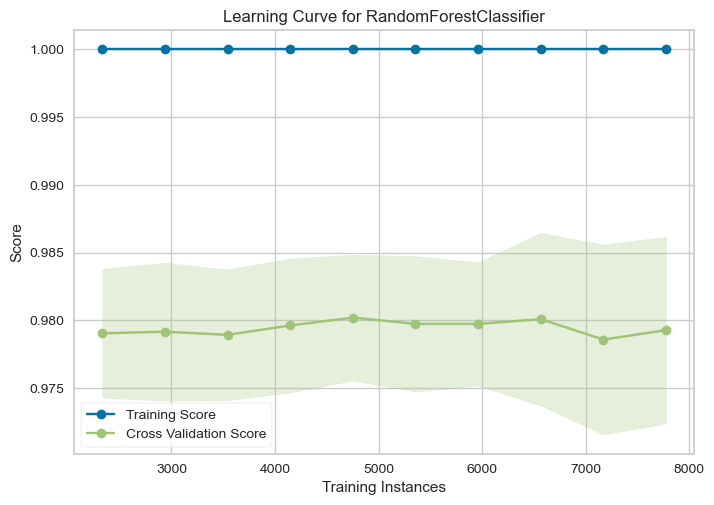

In [20]:
plot_model(
    best_model, 
    plot = 'learning'
)

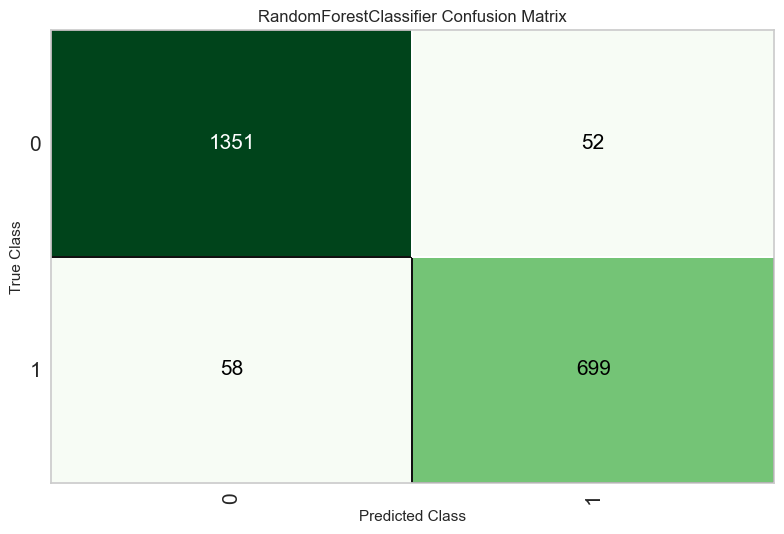

In [21]:
plot_model(
    best_model, 
    plot = 'confusion_matrix'
)

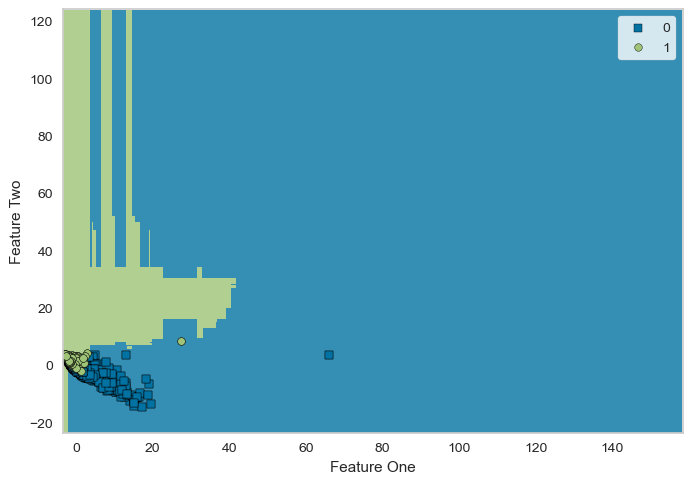

In [22]:
plot_model(
    best_model, 
    plot = 'boundary'
)

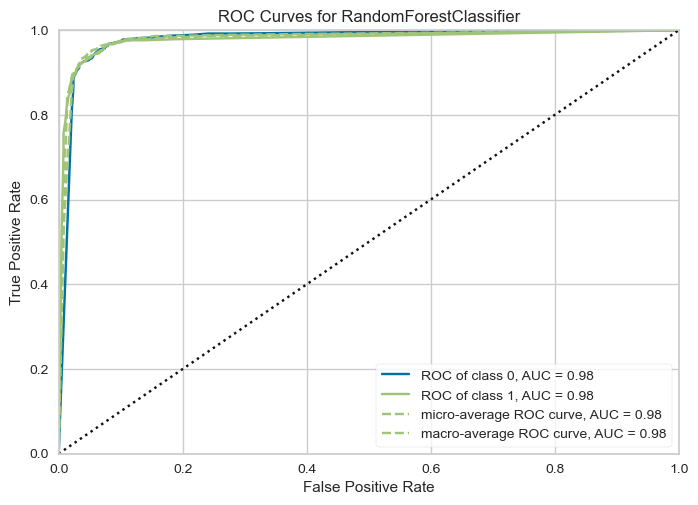

In [23]:
plot_model(
    best_model, 
    plot = 'auc', 
    use_train_data = False
)

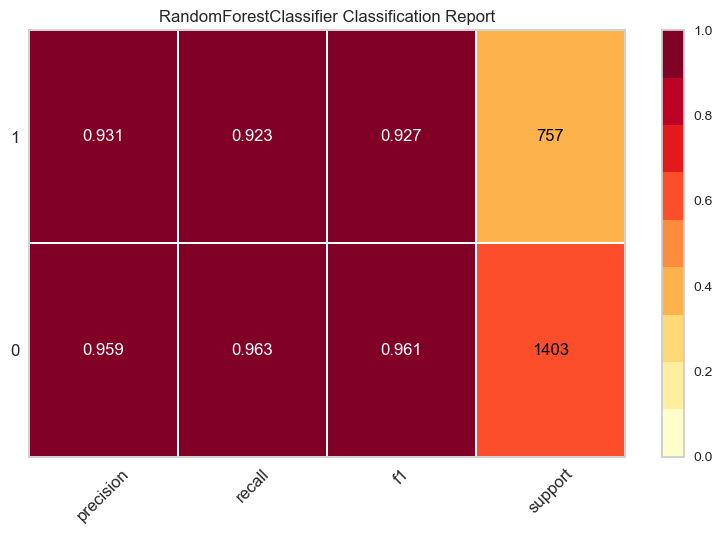

In [24]:
plot_model(
    best_model, 
    plot = 'class_report', 
)